# Time Series Forecasting for AirPassengers:

## Loading Libraries:

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10,6

## Loading Data set:

In [17]:
data = pd.read_csv("AirPassengers.csv")
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [18]:
data['Month'] = pd.to_datetime(data['Month'])
data['Month'] = data['Month'].astype('datetime64[ns]')
data.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [19]:
data = data.set_index('Month')
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [20]:
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

## Converting data in Series object:

In [21]:
ts = data['#Passengers']
ts.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

### Why indexing is important:

In [22]:
#1. Specific the index as a string constant
ts['1949-03-01']

132

In [23]:
#2. Import the datetime library and use 'datetime' function:
from datetime import datetime
ts[datetime(1949,3,1)]

132

In [24]:
#3. Specify the entire range:
ts['1949-01-01':'1949-05-01']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

In [25]:
#4. Use ':' if one of the indices is at ends:
ts[:'1949-05-01']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

In [26]:
#5. Just specific year data.
ts['1950']

Month
1950-01-01    115
1950-02-01    126
1950-03-01    141
1950-04-01    135
1950-05-01    125
1950-06-01    149
1950-07-01    170
1950-08-01    170
1950-09-01    158
1950-10-01    133
1950-11-01    114
1950-12-01    140
Name: #Passengers, dtype: int64

## How to Check Stationarity of a Time Series?
    There are three requirments that given data is stationary or not?
        1. Constant mean
        2. Constant Variance
        3. An autocovariance that does not depend on time

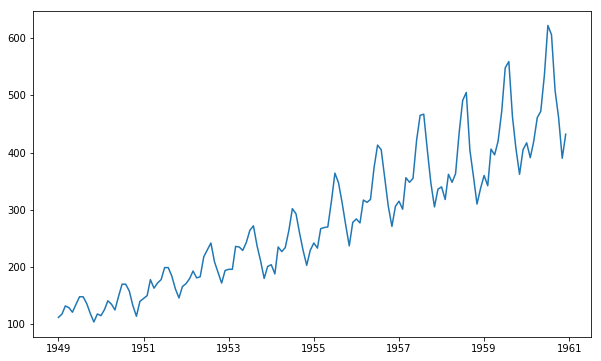

In [27]:
plt.plot(ts)
#t is clearly evident that there is an overall increasing trend in the data along with some seasonal variations.

### To check wheather given TS is stationary or not has two methods:
    1. Plotting Rolling Statistics:
        We can plot the moving average or moving variance and see if it varies with time. 
    2. Dickey Fuller Test:
        This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

In [28]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color = 'blue', label='Orignal')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean 12')
    std = plt.plot(rolstd, color='black', label= 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    print ("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index= ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s) ' %key] = value
    print(dfoutput)

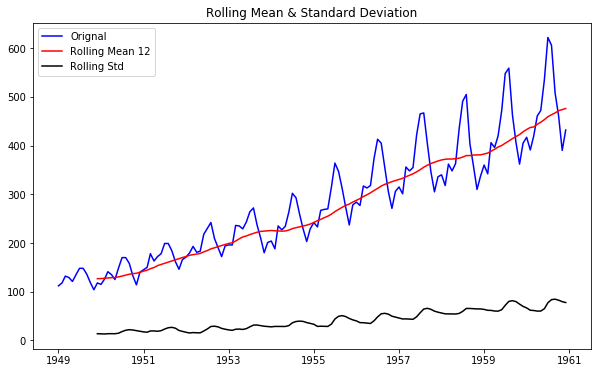

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [29]:
test_stationarity(ts)

    Though the variation in standard deviation is small, mean is clearly increasing with time and this is not a stationary series. 
    
    Also, the test statistic is way more than the critical values. Note that the signed values should be compared and not the absolute values.
    
## How to make a Time Series Stationary?
    There are two ways to make non-stationary TS into stationary:
####        Trends:
            varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.
            
####        Seasonality:
             variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.
             
### Estimating & Eliminating Trend:
    One of the first tricks to reduce trend can be transformation. 
    
#### 1. Transformation:
    For example, in this case we can clearly see that there is a significant positive trend. So we can apply transformation which penalize higher values more than smaller values. These can be taking a log, square root, cube root, etc. Lets take a log transform here for simplicity:

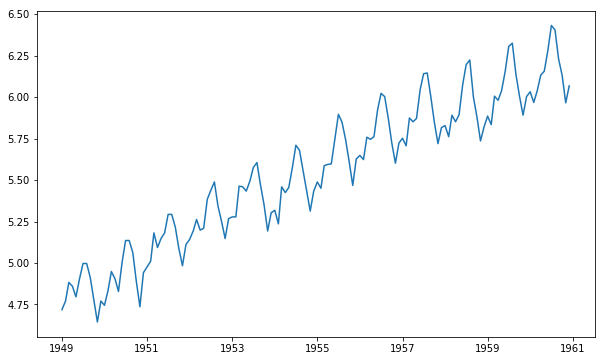

In [30]:
## Taking log
ts_log = np.log(ts)
plt.plot(ts_log)

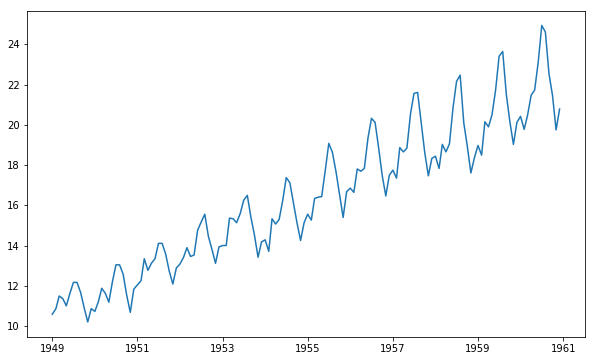

In [31]:
## Taking square root
ts_sqrt = np.sqrt(ts)
plt.plot(ts_sqrt)

In given senario there is a forward trend we can observe. But its not very intuitive in presence of noise. So we can estimate or model some trend and then remove it from the series. There can be many ways but we try most common of them.

    1. Aggregation – taking average for a time period like monthly/weekly averages
    2. Smoothing – taking rolling averages
    3. Polynomial Fitting – fit a regression model

### Moving Average:
    In this approach, we take average of ‘k’ consecutive values depending on the frequency of time series. Here we can take the average over the past 1 year, i.e. last 12 values. Pandas has specific functions defined for determining rolling statistics.

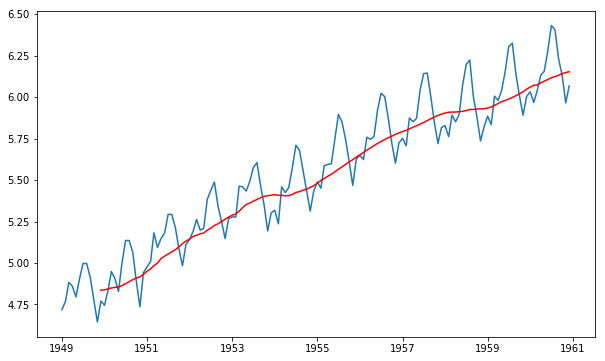

In [32]:
## log
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

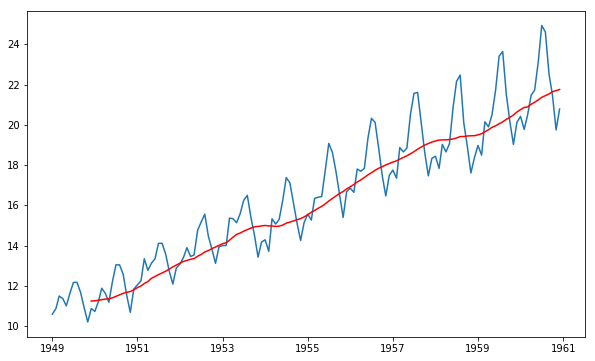

In [33]:
## square root
moving_avg_sqrt = ts_sqrt.rolling(12).mean()
plt.plot(ts_sqrt)
plt.plot(moving_avg_sqrt, color='red')

In [34]:
## log
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(24)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
1950-05-01   -0.027529
1950-06-01    0.139881
1950-07-01    0.260184
1950-08-01    0.248635
1950-09-01    0.162937
1950-10-01   -0.018578
1950-11-01   -0.180379
1950-12-01    0.010818
Name: #Passengers, dtype: float64

In [35]:
## square root
ts_log_moving_avg_diff_sqrt = ts_sqrt - moving_avg
ts_log_moving_avg_diff_sqrt.head(24)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01    6.026602
1950-01-01    5.885424
1950-02-01    6.381124
1950-03-01    7.024998
1950-04-01    6.765817
1950-05-01    6.324497
1950-06-01    7.342490
1950-07-01    8.162790
1950-08-01    8.151242
1950-09-01    7.670147
1950-10-01    6.623635
1950-11-01    5.760501
1950-12-01    6.901335
Name: #Passengers, dtype: float64

Deleting first eleven NaN values, and check the plots to test stationary.

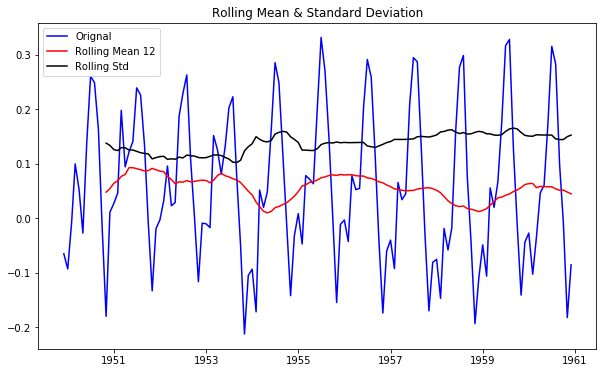

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [36]:
## log
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

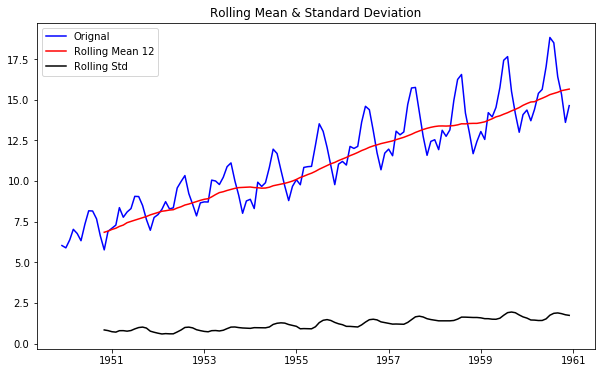

Results of Dickey-Fuller Test:
Test Statistic                  -0.169700
p-value                          0.942038
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [37]:
# square root
ts_log_moving_avg_diff_sqrt.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff_sqrt)

For log transformation we observe that the given TS is stationary but by using square root it is non-stationary.
The aplication of log and sqrt is applied to make TS stationary but it vary problem to problem.

### Stationary Observation:
    Now you can see Moving Average is almost smooth, and also Augmented Dickey–Fuller test (ADF) also has test value ( t-test= -3.162908 ) less than critical value ( 5%=-2.886151 ) so the null hypothesis is rejected and we say now its a stationary TS with 95% confidence.
    
### Drawback of Log transformation:
    In this particular approach is that the time-period has to be strictly defined.
    
### Why we need Exponential Weighted Moving Average:
    When we define fix time-periods. In this case we can take yearly average but but in complex situations like forecasting a stock price, its difficult to come up with a number. So we take a ‘weighted moving average’ where more recent values are given a higher weight. There can be many technique for assigning weights. A popular one is exponentially weighted moving average where weights are assigned to all the previous values with a decay factor. 

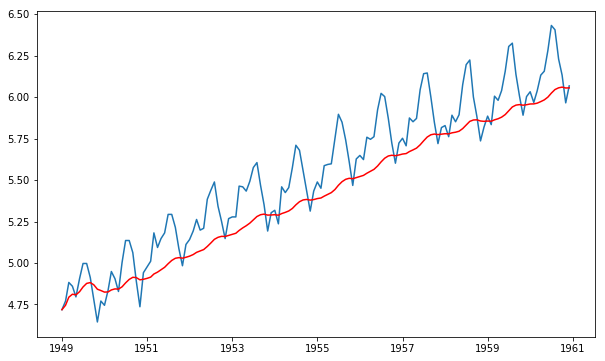

In [38]:
## Exponential Weighted Moving Average:
expwighted_avg = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

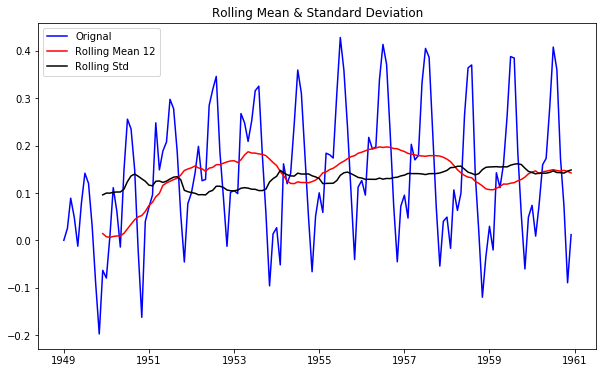

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [39]:
# Now, let’s remove this from series and check stationarity:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

This TS has even lesser variations in mean and standard deviation in magnitude. Also, the test statistic is smaller than the 1% critical value, which is better than the previous case. Note that in this case there will be no missing values as all values from starting are given weights. So it’ll work even with no previous values.

## Eliminating Trend and Seasonality:
    Lets discuss two ways of removing trend and seasonality:

        1. Differencing – taking the differece with a particular time lag
        2. Decomposition – modeling both trend and seasonality and removing them from the model.

## Differencing:

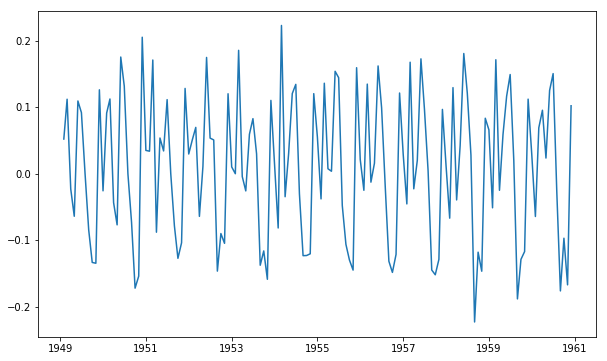

In [79]:
ts_log_diff = ts_log - ts_log.shift(1)
plt.plot(ts_log_diff)

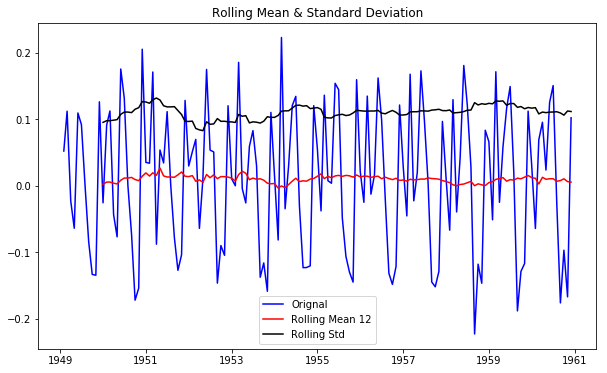

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [80]:

ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

When we take difference with 2 or shift(2) it on Dikey-Fuller Test, statistic is less than critical value of (5%), thus we say TS is stationary with 95% confidence. It produce the same result for almost all even shifts and test statistics value is decreased w.r.t critical value if number of shifts are increased.

## Decomposing:

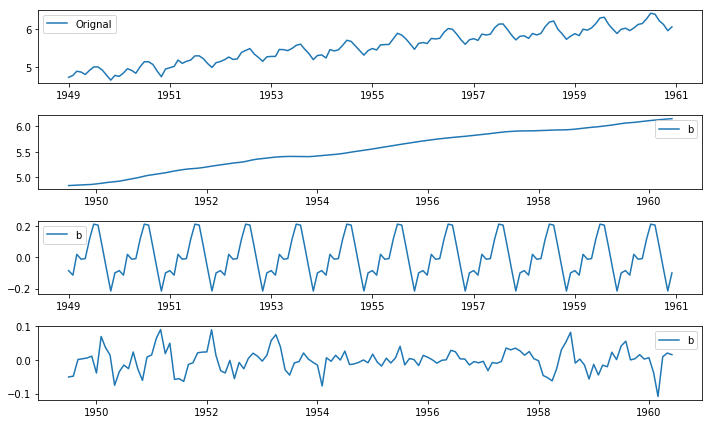

In [81]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Orignal')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend('best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend('best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend('best')
plt.tight_layout()

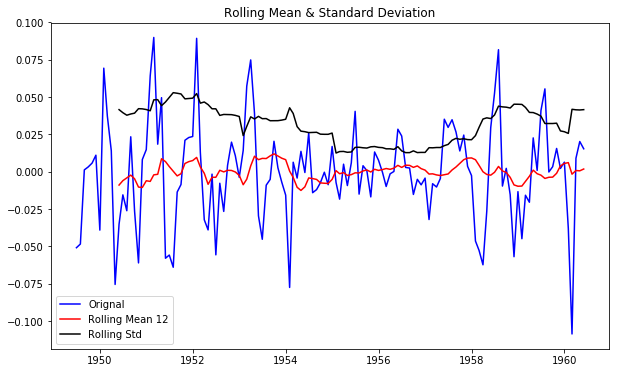

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [82]:
## Here we can see that the trend, seasonality are separated out from data and we can model the residuals. 
##Lets check stationarity of residuals:
ts_log_decomose = residual
ts_log_decomose.dropna(inplace=True)
test_stationarity(ts_log_decomose)

The Dickey-Fuller test statistic is significantly lower than the 1% critical value. So this TS is very close to stationary. 

##  Forecasting a Time Series:
     Lets make model on the TS after differencing as it is a very popular technique. Also, its relatively easier to add noise and seasonality back into predicted residuals in this case. Having performed the trend and seasonality estimation techniques, there can be two situations:
     
####    1. A strictly stationary series 
    with no dependence among the values. This is the easy case where in we can model the residuals as white noise. But this is very rare.
####    2. A series with significant dependence among values. 
    In this case we need to use some statistical models like ARIMA to forecast the data.

## Auto-Regressive Integrated Moving Averages (ARIMA):
    The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:
    
    1. Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
    2. Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
    3. Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.
    
    An importance concern here is how to determine the value of ‘p’ and ‘q’. We use two plots to determine these numbers. Lets discuss them first.
####    1. Autocorrelation Function (ACF): 
        It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).
####    2. Partial Autocorrelation Function (PACF):
        This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

In [83]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

## we can change nlag value depending on situation.
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

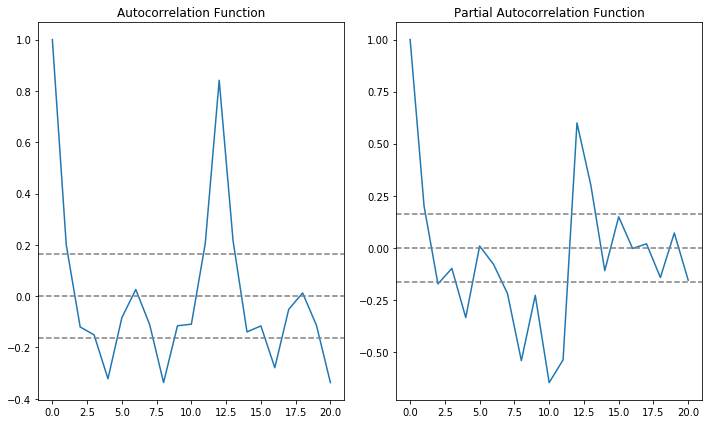

In [84]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In this plot, the two dotted lines on either sides of 0 are the confidence interevals. These can be used to determine the ‘p’ and ‘q’ values as:

p – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=2.
q – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=2.

Now, lets make 3 different ARIMA models considering individual as well as combined effects. I will also print the RSS for each. Please note that here RSS is for the values of residuals and not actual series.

In [85]:
## We need to load the ARIMA model first:

from statsmodels.tsa.arima_model import ARIMA

### AR Model


/home/farhatullah/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/farhatullah/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5,1,'RSS: 1.5023')

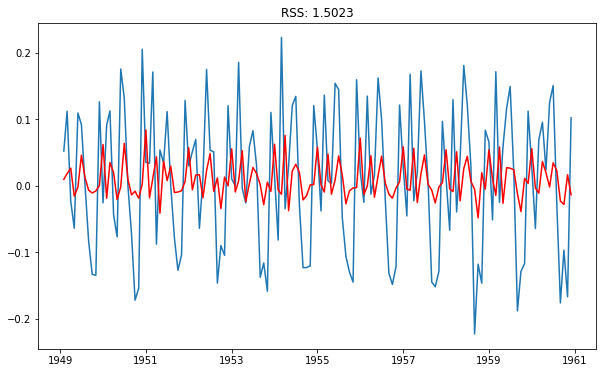

In [88]:
#The p,d,q values can be specified using the order argument of 
#ARIMA which take a tuple (p,d,q). Let model the 3 cases:

model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

### MA Model:

/home/farhatullah/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/farhatullah/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5,1,'RSS: 1.4721')

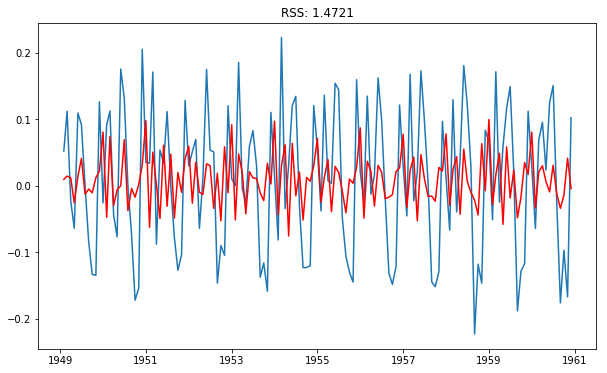

In [87]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

### Combined Model:

/home/farhatullah/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/farhatullah/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5,1,'RSS: 1.0292')

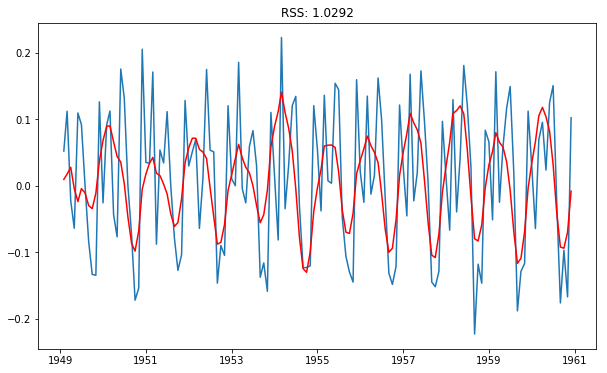

In [116]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

Here we can see that the AR and MA models have almost the same RSS but combined is significantly better. Now, we are left with 1 last step, i.e. taking these values back to the original scale.

### Taking it back to original scale:
    Since the combined model gave best result, lets scale it back to the original values and see how well it performs there. First step would be to store the predicted results as a separate series and observe it.

In [91]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64


Notice that these start from ‘1949-02-01’ and not the first month. Why? This is because we took a lag by 1 and first element doesn’t have anything before it to subtract from. The way to convert the differencing to log scale is to add these differences consecutively to the base number. An easy way to do it is to first determine the cumulative sum at index and then add it to the base number. The cumulative sum can be found as:

In [92]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


Next we’ve to add them to base number. For this lets create a series with all values as base number and add the differences to it. This can be done as:

In [93]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

/home/farhatullah/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

Here the first element is base number itself and from thereon the values cumulatively added. Last step is to take the exponent and compare with the original series.

Text(0.5,1,'RMSE: 90.1049')

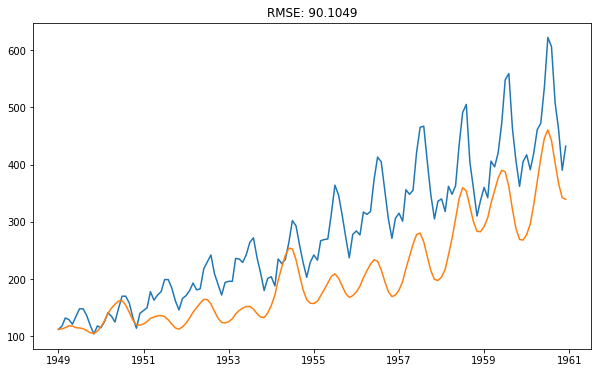

In [94]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

/home/farhatullah/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


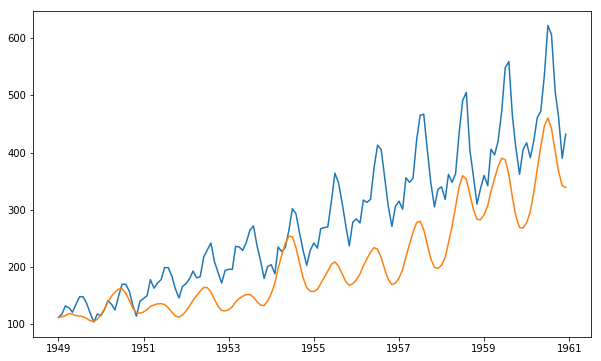

In [101]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)

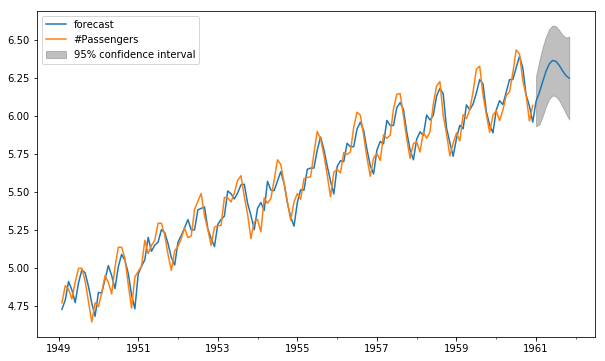

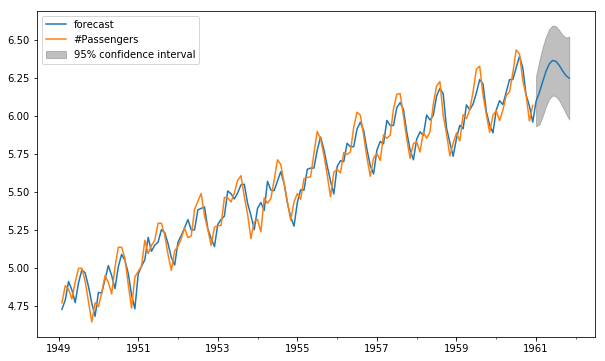

In [119]:
results_ARIMA.plot_predict(1,154)

In [122]:
results_ARIMA.forecast(steps=10)

(array([6.09553397, 6.15281411, 6.22442974, 6.29241107, 6.34164718,
        6.36359357, 6.35784676, 6.33139292, 6.29597528, 6.26447704]),
 array([0.08384711, 0.10749462, 0.11568694, 0.11702775, 0.11703496,
        0.11744017, 0.11762249, 0.11778713, 0.12024162, 0.12736041]),
 array([[5.93119665, 6.25987129],
        [5.94212853, 6.36349969],
        [5.9976875 , 6.45117198],
        [6.0630409 , 6.52178124],
        [6.11226286, 6.57103149],
        [6.13341507, 6.59377208],
        [6.12731091, 6.58838262],
        [6.10053439, 6.56225145],
        [6.06030603, 6.53164453],
        [6.01485521, 6.51409886]]))